# Predicting DSAIL-Porini dataset animals
!['DSAIL DSA Arusha 2022'](./figures/dsa-arusha-dsail-logo.PNG)


The animals are the ones below :
!['conservancy animals'](./figures/conservancy-animals.PNG)

Below I'll take you through a process of predicting what animal is in what image

First, we will use mobilenet model with imagenet weights. The imagenet classes have 3 out of 6 of the DSAIL-Porini classes. [imagenet classes](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
)

# 1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
#use reducelronplateau and lrscheduling
#use transfer learning.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import cv2
import io
import random
from PIL import Image
import time

from sklearn.model_selection import train_test_split
# Import models
from tensorflow.keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import PIL
from keras.utils.vis_utils import plot_model
from IPython import display

import warnings
warnings.simplefilter("ignore")

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
print('Libraries imported')

Libraries imported


In [2]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


def get_score(preds,trues,score,description,species):
    animal = species
    predictions = [int(pred==species) for pred in list(preds)]
    true_labels = [1 for label in list(trues)]
    y_pred,y_act = predictions,true_labels
    score = score(y_act, y_pred)
    return score
def get_scores_and_plot(score,score_desc):
    s1 = []
    s2 = []
    tx1 = []
    tx2 = []
    
    for animal in list(reverse_mapping.values()):
        df = df_pretrained[df_pretrained['true']==animal]
        df = df[df['pred']!=6]
        s1.append(get_score(df['pred'],df['true'],score,score_desc+"Smaller model on Uncropped data on ",animal))
        df = df_small_conv[df_small_conv['true']==animal]
        s2.append(get_score(df['pred'],df['true'],score,score_desc+"Smaller model on Cropped data on ",animal))
        df = df_mobilenet[df_mobilenet['true']==animal]
        tx1.append(get_score(df['pred'],df['true'],score,score_desc+"Inception Resnet on Uncropped data on ",animal))
        df = df_your_model[df_your_model['true']==animal]
        tx2.append(get_score(df['pred'],df['true'],score,score_desc+"Inception Resnet on Cropped data on ",animal))
    
    #Graph
    # set width of bar
    barWidth = 0.2
    fig = plt.subplots(figsize =(12, 5))

    # set height of bar
    small_uncropped = s1
    small_cropped = s2
    Inception_Resnet_uncropped = tx1
    Inception_Resnet_cropped = tx2

    # Set position of bar on X axis
    br1 = np.arange(len(small_uncropped))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
    plt.bar(br1, small_uncropped, color ='r', width = barWidth,
            edgecolor ='grey', label ='pretrained')
    plt.bar(br2, small_cropped, color ='g', width = barWidth,
            edgecolor ='grey', label ='small_conv')
    plt.bar(br3, Inception_Resnet_uncropped, color ='b', width = barWidth,
            edgecolor ='grey', label ='mobilenet')
    plt.bar(br4, Inception_Resnet_cropped, color ='y', width = barWidth,
            edgecolor ='grey', label ='your-model')

    # Adding Xticks
    plt.xlabel('model', fontweight ='bold', fontsize = 15)
    plt.ylabel(score_desc, fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(small_uncropped))],
            ['BUSHBUCK', 'IMPALA', 'MONKEY', 'WARTHOG', 'WATERBUCK','ZEBRA'])

    plt.legend()
    plt.show()
print('Imported Custom Functions')

Imported Custom Functions


In [3]:
# set seed for reproducibility.
# set seed
seed = 2022

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed)



# 2 Get Data

### Get directory names.

In [4]:
#set directories.
base_dir = './data/porinicroppedimages/dataset/'

# Directory with our training images
train_dir = os.path.join(base_dir, 'train/')

print(train_dir)

#Directory with test images.
test_dir = os.path.join(base_dir, 'test/')
print(test_dir)
#make sure file path ends with a forward slash.

./data/porinicroppedimages/dataset/train/
./data/porinicroppedimages/dataset/test/


### Number of Images in train and test.


In [5]:
print('total training train images :', len(os.listdir(train_dir ) ))
print('total training test images :', len(os.listdir(test_dir ) ))

total training train images : 2086
total training test images : 236


In [6]:
#get data
df_train = pd.read_csv(base_dir + 'train.csv')
print(df_train.shape)
df_test = pd.read_csv(base_dir + 'test.csv')
print(df_test.shape)

(2086, 9)
(236, 9)


Before you train the model for prediction, you need to perform data [cleaning](https://www.dataquest.io/blog/machine-learning-preparing-data/) and [preprocessing](https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825). This is a very important step; your model will not perform well without these steps.

![process image](./figures/process-data-science.PNG)


#### Description
filename -  image name in test or train
region_count - count of crop to regions
region_shape_attributes - The region in the image where the animal is. Here the dataset has already been autocropped but if you download the [whole dataset](https://data.mendeley.com/datasets/6mhrhn7rxc/6)
Device - Camera trap device used to capture the image i.e. 'Raspberry Pi 2', 'Raspberry Pi Zero', 'OpenMV Cam H7'
Species - Animal i.e. 'WARTHOG', 'IMPALA', 'WATERBUCK', 'ZEBRA', 'MONKEY', 'BUSHBUCK'
Count - animals in image
Sex - Is the animal Male, Femal or Can't tell
Latitude and Longitude - position of camera trap

In [7]:
df_train.shape

(2086, 9)

In [8]:
df_test.head()

,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude
0,2021-09-29-13-44-42.jpg,1,"{""name"":""rect"",""x"":957,""y"":388,""width"":262,""he...",Raspberry Pi 2,MONKEY,1,CAN'T TELL,-0.386616,36.965402
1,2021-09-29-13-51-48.jpg,1,"{""name"":""rect"",""x"":990,""y"":419,""width"":238,""he...",Raspberry Pi 2,MONKEY,1,CAN'T TELL,-0.386616,36.965402
2,2021-11-02-08-37-48.jpg,1,"{""name"":""rect"",""x"":8,""y"":323,""width"":934,""heig...",Raspberry Pi 2,MONKEY,1,CAN'T TELL,-0.388557,36.961391
3,2021-12-09-15-02-37.jpg,1,"{""name"":""rect"",""x"":919,""y"":379,""width"":96,""hei...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.390772,36.962500
4,2021-12-09-15-02-40.jpg,1,"{""name"":""rect"",""x"":919,""y"":379,""width"":96,""hei...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.390772,36.962500


# 3 Exploratory Data Analysis

### Animal vs Location
- We have 6 animals, Where are they

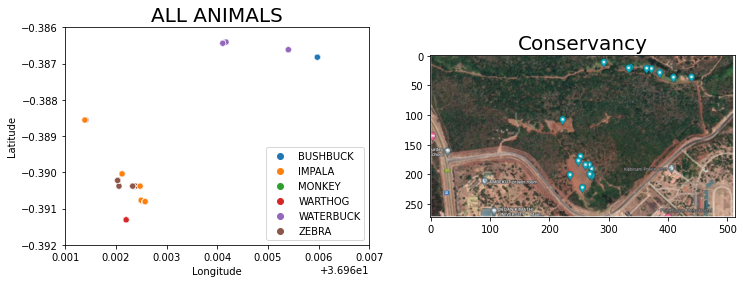

In [9]:
#create the figure
fig = plt.figure(figsize =(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('ALL ANIMALS',fontdict = {'fontsize':20})
plt.ylim([-0.392,-0.386])
plt.xlim(36.961,36.967)
imgplot =  sns.scatterplot(data=df_train,x='Longitude',y='Latitude',hue='Species',hue_order = ['BUSHBUCK','IMPALA','MONKEY','WARTHOG','WATERBUCK','ZEBRA']);
plt.legend(loc='lower right')
ax = fig.add_subplot(1,2,2)
ax.set_title('Conservancy',fontdict = {'fontsize':20})
image_ = mpimg.imread('./figures/conservancy.PNG')
imgplot = plt.imshow(image_)
plt.show()

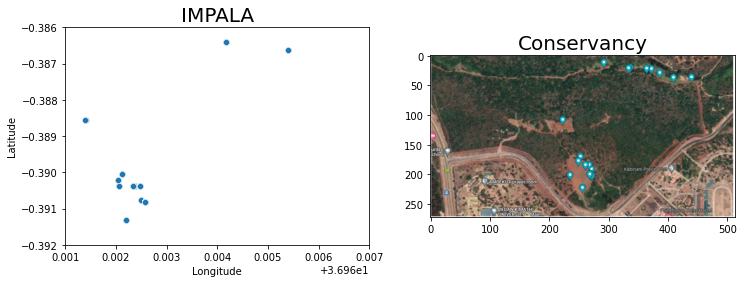

In [10]:
#create the figure
animal = 'IMPALA'
def animal_location(animal):
    fig = plt.figure(figsize =(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.ylim([-0.392,-0.386])
    plt.xlim(36.961,36.967)
    ax.set_title(animal,fontdict = {'fontsize':20})
    imgplot =  sns.scatterplot(data=df_train[df_train['Species']==animal],x='Longitude',y='Latitude');
    ax = fig.add_subplot(1,2,2)
    image_ = mpimg.imread('./figures/conservancy.PNG')
    ax.set_title('Conservancy',fontdict = {'fontsize':20})
    
    imgplot = plt.imshow(image_)
    plt.show()
animal_location(animal)

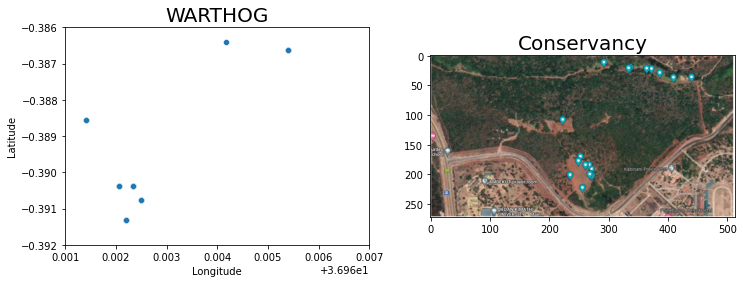

In [11]:
#create the figure
animal = 'WARTHOG'
animal_location(animal)

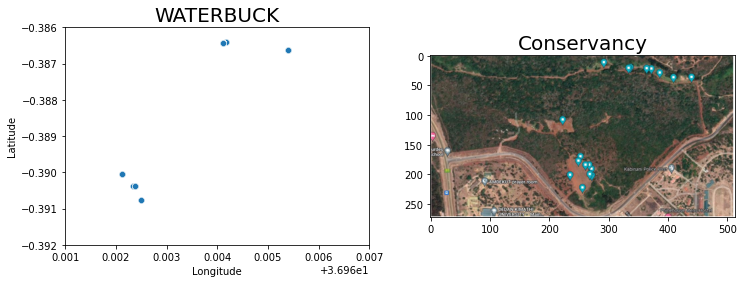

In [12]:
#create the figure
animal = 'WATERBUCK'
animal_location(animal)

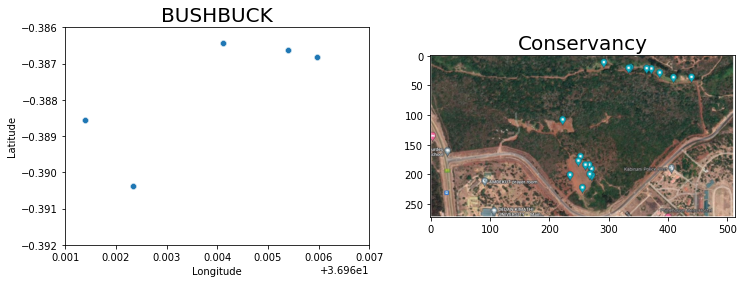

In [13]:
#create the figure
animal = 'BUSHBUCK'
animal_location(animal)

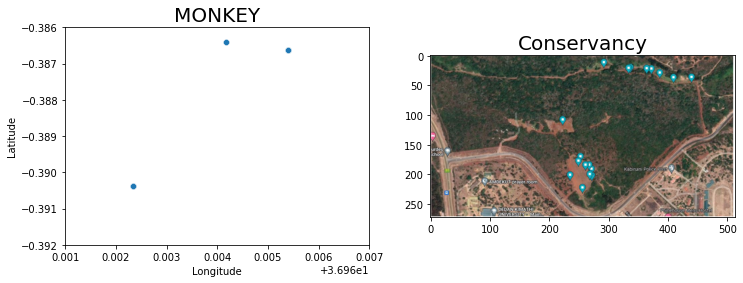

In [14]:
#create the figure
animal = 'MONKEY'
animal_location(animal)

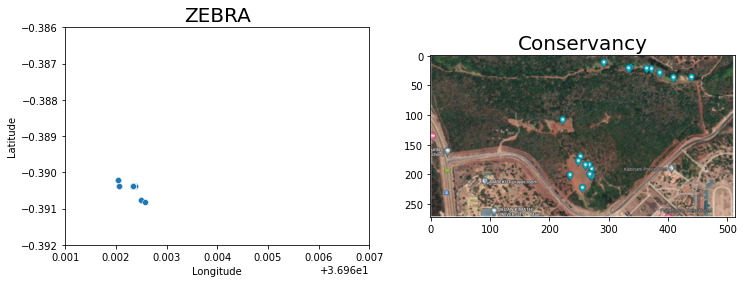

In [15]:
#create the figure
animal = 'ZEBRA'
animal_location(animal)

### Insights

Animals move around, location cant be used to predict what animal is where

### Why did we crop the porini images

1. Increase visibility of animal (Reduce background)

2. Reduce dataset (if unnessarily large) 1.3GB (Single Porini Images) -> 13MB (Single Cropped Porini Images)

2021-12-25-17-59-41.jpg


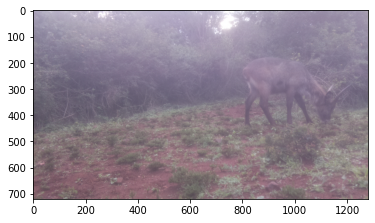

In [16]:
samples = './data/samples/'
random_image = random.choice([f for f in os.listdir(samples) if '.jpg' in f])
print(random_image)
plt.imshow(mpimg.imread(samples+random_image));
plt.show()

2021-12-25-17-59-41.jpg


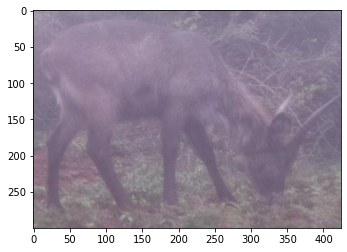

In [17]:
print(random_image)
img = mpimg.imread(test_dir+random_image)
plt.imshow(img)
plt.show()

In [18]:
#shape of the dataframes ?
print('Train labels :',df_train.shape)
print('Test labels :',df_test.shape)

test_ = df_test.shape[0]*["test"]
train_ = df_train.shape[0]*["train"]
df_test["df"] = test_
df_train["df"] = train_

#shape of the dataframes ?
print('Train labels :',df_train.shape)
print('Test labels :',df_test.shape)


Train labels : (2086, 9)
Test labels : (236, 9)
Train labels : (2086, 10)
Test labels : (236, 10)


In [19]:
df = pd.concat([df_train, df_test])

In [20]:
df.head()

,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude,df
0,2021-06-25-14-55-23.jpg,1,"{""name"":""rect"",""x"":1228,""y"":507,""width"":27,""he...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
1,2021-06-25-15-06-49.jpg,1,"{""name"":""rect"",""x"":60,""y"":385,""width"":39,""heig...",Raspberry Pi 2,IMPALA,1,CAN'T TELL,-0.388557,36.961408,train
2,2021-06-25-15-39-54.jpg,1,"{""name"":""rect"",""x"":6,""y"":392,""width"":42,""heigh...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
3,2021-06-25-15-40-46.jpg,1,"{""name"":""rect"",""x"":25,""y"":392,""width"":41,""heig...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
4,2021-07-01-06-51-57.jpg,1,"{""name"":""rect"",""x"":663,""y"":413,""width"":45,""hei...",Raspberry Pi 2,IMPALA,1,FEMALE,-0.390386,36.962331,train


In [21]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["Species_code"] = ord_enc.fit_transform(df[["Species"]])
df.groupby(["Species"])['Species_code'].mean()

Species
BUSHBUCK     0.0
IMPALA       1.0
MONKEY       2.0
WARTHOG      3.0
WATERBUCK    4.0
ZEBRA        5.0
Name: Species_code, dtype: float64

Split train and test set

In [22]:
df_train = df[df['df'] == "train"]
df_test = df[df['df'] == "test"]

Sanity Check on split

In [23]:
num = 0
for file in list(df_train.filename):
    if file in os.listdir(train_dir):
        continue
    else:
        num +=1
if num == 0:
    print('Good Split!')
else:
    print('Error in split')

Good Split!


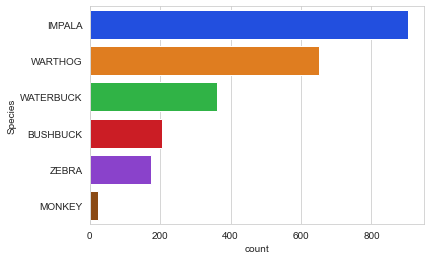

In [24]:
#Plot Class Distribution
sns.set_style('whitegrid')
sns.countplot(y = df['Species'], data = df, palette = 'bright',order=df['Species'].value_counts().index);

In [25]:
#To add Compare your model with pretrained model.
reverse_mapping = {
"BUSHBUCK":0.0,
"IMPALA":1.0,
"MONKEY":2.0,
"WARTHOG":3.0,
"WATERBUCK":4.0,
"ZEBRA":5.0,
}
mapping = {
    0.0:"BUSHBUCK",
    1.0:"IMPALA",
    2.0:"MONKEY",
    3.0:"WARTHOG",
    4.0:"WATERBUCK",
    5.0:"ZEBRA"
}
print(list(reverse_mapping.values()))
print(list(mapping.values()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
['BUSHBUCK', 'IMPALA', 'MONKEY', 'WARTHOG', 'WATERBUCK', 'ZEBRA']


# First pretrained model

### Imagenet labels
Imagenet was trained on 1000 classes of animals while porini has 6 classes.
As a first step: we obtain a model trained on imagenet and try to predict classes of the images.

In [26]:
#load model
model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000)

In [27]:
#model.summary()

In [28]:
preds = {}

for image in os.listdir(test_dir):
        x = tf.io.read_file(test_dir+image)
        x = tf.io.decode_image(x,channels=3) 
        x = tf.image.resize(x,[224,224])
        x = tf.expand_dims(x, axis=0)
        x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
        abc = model.predict(x)
        p = tf.keras.applications.imagenet_utils.decode_predictions(
            abc, top=1
        )[0]
        preds[image] = [image,p[0][1],p[0][2]]
print("Done!")

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 52ms/step
Done!


In [29]:
len(preds)

236

In [30]:
#preds
df = pd.DataFrame.from_dict(preds, orient='index',columns=['Filename', 'class', 'confidence'])
df.head()

,Filename,class,confidence
2021-09-29-13-44-42.jpg,2021-09-29-13-44-42.jpg,guenon,0.314908
2021-09-29-13-51-48.jpg,2021-09-29-13-51-48.jpg,guenon,0.376683
2021-11-02-08-37-48.jpg,2021-11-02-08-37-48.jpg,wreck,0.045206
2021-12-09-15-02-37.jpg,2021-12-09-15-02-37.jpg,velvet,0.803580
2021-12-09-15-02-40.jpg,2021-12-09-15-02-40.jpg,velvet,0.868584


##### save predictions

In [31]:
df.to_csv('./data/pretrained_cropped_predictions.csv', index = False)

##### load predictions

In [32]:
df_preds = pd.read_csv('./data/pretrained_cropped_predictions.csv')
df = df_preds.copy()

In [33]:
df_preds['confidence'].mean()

0.36548931548728814

In [34]:
animals = df_preds['class'].unique()
print(len(animals),animals)

58 ['guenon' 'wreck' 'velvet' 'milk_can' 'skunk' 'platypus' 'ox' 'tusker'
 'wild_boar' 'hog' 'langur' 'gazelle' 'water_buffalo' 'hippopotamus'
 'stingray' 'bison' 'warthog' 'bighorn' 'red_wolf' 'Weimaraner' 'dugong'
 'matchstick' 'geyser' 'Arctic_fox' 'jellyfish' 'kelpie' 'dhole' 'cougar'
 'Scottish_deerhound' 'lion' 'dingo' 'redbone' 'sorrel' 'impala'
 'Arabian_camel' 'Saluki' 'baboon' 'cliff_dwelling' 'alp' 'cliff'
 'sloth_bear' 'brown_bear' 'African_hunting_dog' 'hartebeest'
 'Tibetan_mastiff' 'zebra' 'Windsor_tie' 'nematode' 'nail' 'tiger'
 'electric_fan' 'patas' 'ostrich' 'bow' 'croquet_ball' 'cockroach'
 'Indian_elephant' 'bulletproof_vest']


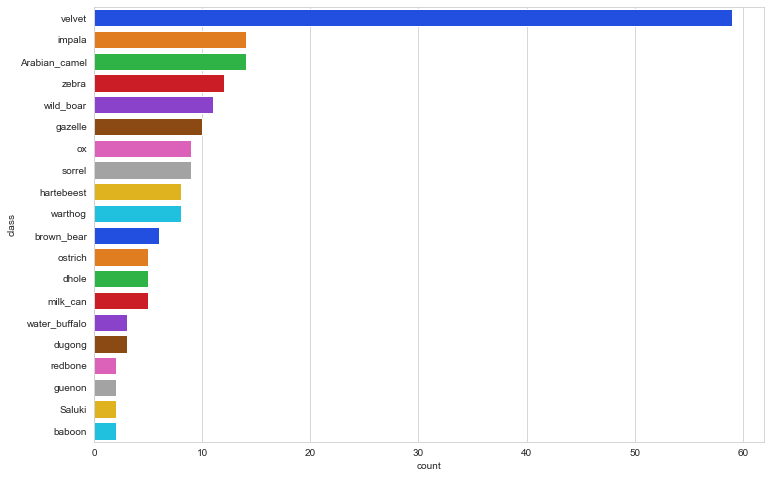

In [35]:
fig = plt.figure(figsize =(12, 8))
#impala,zebra,warthog --- they sum up to 34
#Plot Class Distribution
sns.set_style('whitegrid')
sns.countplot(y = df_preds['class'], data = df_preds, palette = 'bright',order=df_preds['class'].value_counts()[:20].index);

In [36]:
converter = pd.read_csv('./data/newimagenet_class.csv')
df_preds_cropped = pd.read_csv('./data/pretrained_cropped_predictions.csv')
df_test = pd.read_csv('./data/porinicroppedimages/dataset/test.csv')

In [37]:
converter_dict = {}
porini = ['monkey','warthog','waterbuck','impala','bushbuck','zebra']
for i in range(converter.shape[0]):
    #print(converter.to_dict()['imagenet_class'][i] , converter.to_dict()['new_class'][i])
    new = converter.to_dict()['new_class'][i]
    if new not in porini:
        converter_dict[converter.to_dict()['imagenet_class'][i]] = 'none'
    else:
        converter_dict[converter.to_dict()['imagenet_class'][i]] = new

In [38]:
preverse_mapping = {
"BUSHBUCK":0.0,
"IMPALA":1.0,
"MONKEY":2.0,
"WARTHOG":3.0,
"WATERBUCK":4.0,
"ZEBRA":5.0,
"NONE":6.0
}
preds = list(df_preds_cropped['class'])
new_preds = [converter_dict[p] for p in preds]
df_preds_cropped['pred_class'] = new_preds
df_preds_cropped['pred_class']= df_preds_cropped['pred_class'].str.upper()
df_preds_cropped['pred'] = [int(preverse_mapping[p]) for p in list(df_preds_cropped['pred_class'])]

In [39]:
df_preds_cropped['true_class'] = list(df_test['Species'])
df_preds_cropped['true'] = [int(reverse_mapping[p]) for p in list(df_preds_cropped['true_class'])]

In [40]:
df_preds_cropped.head()

,Filename,class,confidence,pred_class,pred,true_class,true
0,2021-09-29-13-44-42.jpg,guenon,0.314908,NONE,6,MONKEY,2
1,2021-09-29-13-51-48.jpg,guenon,0.376683,NONE,6,MONKEY,2
2,2021-11-02-08-37-48.jpg,wreck,0.045206,NONE,6,MONKEY,2
3,2021-12-09-15-02-37.jpg,velvet,0.803580,NONE,6,WARTHOG,3
4,2021-12-09-15-02-40.jpg,velvet,0.868584,NONE,6,WARTHOG,3


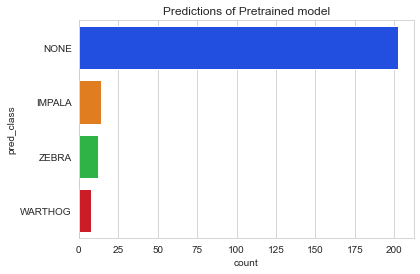

In [41]:
sns.set_style('whitegrid')
sns.countplot(y = df_preds_cropped['pred_class'], data = df_preds_cropped, palette = 'bright',order=df_preds_cropped['pred_class'].value_counts().index);
plt.title('Predictions of Pretrained model');

### Save predictions for analysis

In [42]:
df_preds_cropped.to_csv('./outputs/pretrained_cropped_predictions.csv',index=False)

##### some insights
- mobilenet predicted 58 classes while porini has 6 classes
- only 3 of the classes were available
-most predictions were wrong 
- these aren't the best condition for results.


We'll train models and see whether we can obtain better results.

# Let's train some models

# 4 Data Preprocessing 
(remove faults , size the images, remove nonesense data as seen visually, possible segmentation )

In [43]:
# convert label to string
df_train = df_train.astype({"Species_code": str})

In [44]:

#split to train and test sets, for tuning, for now.
# If you comment out this section during training for inference,
# the model will have a better performance.

train, val = train_test_split(df_train, test_size = 0.113, random_state = seed)
print(train.shape, val.shape)


(1850, 11) (236, 11)


In [45]:
train.head()

,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude,df,Species_code
541,2021-11-26-07-52-29.jpg,1,"{""name"":""rect"",""x"":121,""y"":376,""width"":78,""hei...",Raspberry Pi 2,IMPALA,1,CAN'T TELL,-0.390224,36.962036,train,1.0
920,2021-12-08-15-20-00.jpg,1,"{""name"":""rect"",""x"":1207,""y"":412,""width"":69,""he...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.390772,36.962500,train,3.0
113,2021-10-02-15-35-36.jpg,1,"{""name"":""rect"",""x"":700,""y"":316,""width"":131,""he...",Raspberry Pi 2,IMPALA,1,FEMALE,-0.390772,36.962500,train,1.0
1534,2021-12-23-17-42-32.jpg,1,"{""name"":""rect"",""x"":370,""y"":402,""width"":93,""hei...",Raspberry Pi Zero,BUSHBUCK,1,MALE,-0.386438,36.964109,train,0.0
688,2021-12-08-15-10-38.jpg,1,"{""name"":""rect"",""x"":568,""y"":366,""width"":79,""hei...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.390772,36.962500,train,3.0


#### What are the image sizes


In [46]:
#median size of images is width=96.0, height=78.0
#mean size of images is width=160, height=149
size = (128,128)
batch_size = 32
train_size = train.shape[0]
val_size = val.shape[0]

#to train on whole data per iteration
train_steps_per_epoch = int(train_size/batch_size) #int here used to round off
val_steps_per_epoch = int(val_size/batch_size) #int here used to round off

print('Batch size : ',batch_size)
print('Train size : ',train_size)
print('Val size : ',val_size)
print('Train steps per epoch : ',train_steps_per_epoch)
print('Val steps per epoch : ',val_steps_per_epoch)


Batch size :  32
Train size :  1850
Val size :  236
Train steps per epoch :  57
Val steps per epoch :  7


# 5 Image Feature Engineering and Image Augmentation. 

#### There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

*  Data augmentation is inactive at test time so input images will only be augmented during calls to model.fit (not model.evaluate or model.predict).

* You can augment your data to see how they'll impact the training.
*For a start we use non augmented data. 

<a id='another_cell'></a>
### Augmentation Section

In [47]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(   
                # rotation_range = 30,
                # width_shift_range = 0.2,#
                # height_shift_range = 0.2,#
                # brightness_range = [0.5,1.5],#
                # horizontal_flip = True,
                # fill_mode = 'nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [48]:
train_generator = train_datagen.flow_from_dataframe(
                    train,
                    directory = train_dir,
                    x_col = "filename",
                    y_col = "Species_code",
                    target_size = size,
                    class_mode = "categorical",
                    batch_size = batch_size,
                    shuffle = True,
                    seed = seed,
                    interpolation = "nearest",
                    #validate_filenames=False
)
val_generator = val_datagen.flow_from_dataframe(
                    val,
                    directory = train_dir, #valid is from train
                    x_col = "filename",
                    y_col = "Species_code",
                    target_size = size,
                    class_mode = "categorical",
                    batch_size = batch_size,
                    shuffle = True,
                    seed = seed,
                    interpolation = "nearest"
)


Found 1850 validated image filenames belonging to 6 classes.
Found 236 validated image filenames belonging to 6 classes.


### Visualize augmentations.


#### Image before augmentation.

In [49]:
#Random Image
rand_image = random.choice(os.listdir(train_dir))

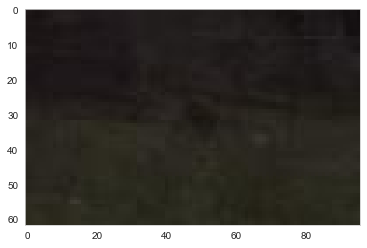

In [50]:
img = cv2.imread(os.path.join(train_dir,rand_image))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.grid(None)

#### After augmentation

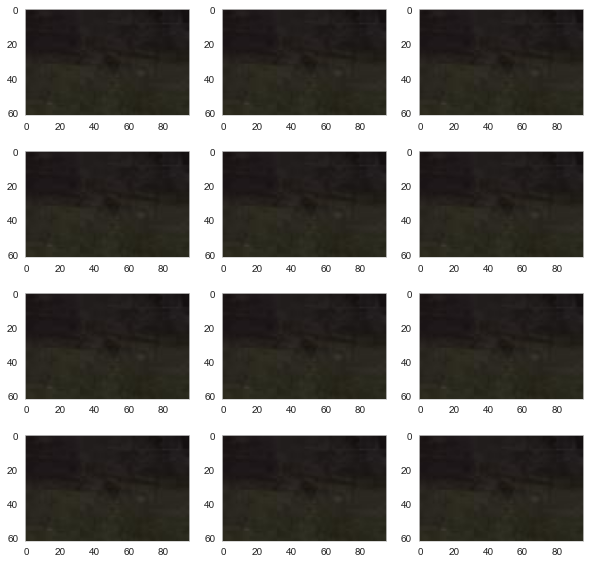

In [51]:
plt.figure(figsize = (10,10))
# set the title
plt.title('Augmented Images')
# load the image
img = tf.keras.preprocessing.image.load_img(os.path.join(train_dir,rand_image))
# convert to numpy array
data = tf.keras.preprocessing.image.img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# iterator
itr = train_datagen.flow(samples, batch_size = 1)
# generate samples and plot
for i in range(12):
    # define subplot
    plt.subplot(4,3,i+1)
    # generate batch of images
    batch = itr.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    plt.grid(None)
# show the figure
plt.show()

#play around with this.

# 6 Task to you:
#### Add agumentations that you think will improve the model accuracy

### you can try them on the   [Augmentation Section](#another_cell)

* Activating the contraints in ImageDataGenerator 
* Color modification
* Convolution filters
* rotate, rescale, translate
* darkening and brightening

# 7 Modelling

In [52]:
shape=(size[0],size[1],3)

#### Select the model you want to use

1. for a simple model
2. for mobilenet_v2

##### if your internet is not as fast as you'd want : pick 1

In [53]:
select = int(input("Select model you want to use 1 or 2"))
if select == 1 :
    print("Selected simple model") #takes aprroximately 60s per epoch
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    name = 'model'

elif select == 2 :
    print("Selected mobilenet")
    model = MobileNetV2(weights = 'imagenet', include_top=False, input_shape=shape)
    model.trainable = False
    gmaxpool2 = tf.keras.layers.GlobalMaxPooling2D()(model.layers[-1].output)
    dense2 = tf.keras.layers.Dense(512, activation='relu')(gmaxpool2)
    output2 = tf.keras.layers.Dense(6, activation='softmax')(dense2)
    model = tf.keras.Model(inputs=[model.inputs], outputs=output2)
    name = 'mobilenet'
else:
    print("Error in selection")
print("Saved model will be : ",name,'.h')

Select model you want to use 1 or 22
Selected mobilenet
Saved model will be :  mobilenet .h


In [54]:
#see whole model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

#### Callbacks
#### Learning rate scheduler
Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train

#### Modelcheckpoints
ModelCheckpoint callback is used in conjunction with training using model. fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved

In [55]:
#Add Learning rate scheduler.
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler#set_model
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
callback_lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Early Stopping
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.001)

In [56]:
start_load = time.process_time()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print('Compiled')
#Save Best model check points

checkpoint_filepath = './'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 1
    )


history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=train_steps_per_epoch, #calculated up to standard. train_size/batch_size
    validation_data = val_generator, 
    verbose = 1,
    validation_steps=val_steps_per_epoch,
    callbacks = [callback_lrs, reduce_lr,model_checkpoint_callback, callback_earlystopping],
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


model.save("models/"+name+".h5")
stop_load = time.process_time()
print('Time taken by for loop: ',stop_load-start_load)

Compiled
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 2.7944 - accuracy: 0.4972
Epoch 1: val_accuracy improved from -inf to 0.45982, saving model to .\
57/57 [==============================] - 40s 588ms/step - loss: 2.7944 - accuracy: 0.4972 - val_loss: 1.7260 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.6227
Epoch 2: val_accuracy improved from 0.45982 to 0.65625, saving model to .\
57/57 [==============================] - 37s 653ms/step - loss: 1.0662 - accuracy: 0.6227 - val_loss: 0.9364 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.6788
Epoch 3: val_accuracy did not improve from 0.65625
57/57 [==============================] - 33s 576ms/step - loss: 0.8466 - accuracy: 0.6788 - val_loss: 0.9444 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 0.6967 -

# 8 Model Evaluation 

Proper training over 100 epochs should have this kind of smooth trend:
![image](./figures/training-validation-recall.PNG)

In [57]:
model.evaluate_generator(generator = val_generator, steps = val_steps_per_epoch)

[0.5887539982795715, 0.8348214030265808]

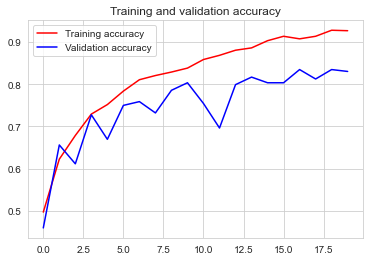

<Figure size 432x288 with 0 Axes>

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

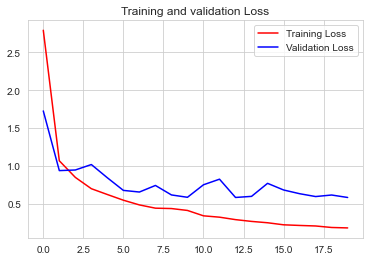

<Figure size 432x288 with 0 Axes>

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('models/recall_history.csv',index=False)

### Let's look at a few random predictions

In [60]:
def predict_single_image(directory,random_image=''):
    if len(random_image) == 0 :
        random_image = random.choice(os.listdir(directory))
    #plotting the image
    image_ = mpimg.imread(directory+random_image) 
    #obtaining the image as an array for prediction
    img = Image.open(directory + random_image) 
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0]
    
    #create the figure
    fig = plt.figure(figsize =(12, 4))
    #subplot for the image
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(image_)
    ax.grid(None)
    title = df_test.loc[df_test['filename'] ==random_image].Species.values[0]
    ax.set_title(title)
    
    x = ['bushbuck','impala','monkey','warthog','waterbuck','zebra']
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.bar(x,prediction,color=['b','y','g','r','c','k'])
    ax.grid(None)
    ax.set_title('Confidence')
    plt.show()
    return random_image

##### Prediction on uncropped image

1/1 [==============================] - 0s 24ms/step


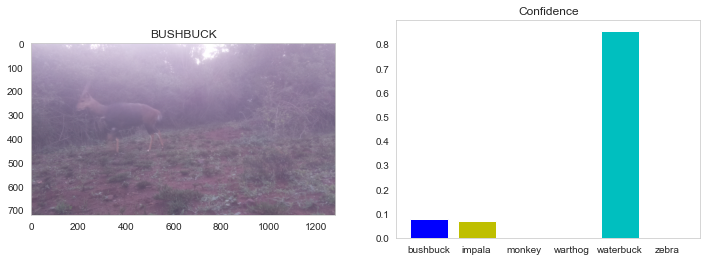

In [133]:
random_image = random.choice(os.listdir('./data/samples/'))
random_image = predict_single_image('./data/samples/')

##### Prediction on cropped image

1/1 [==============================] - 0s 53ms/step


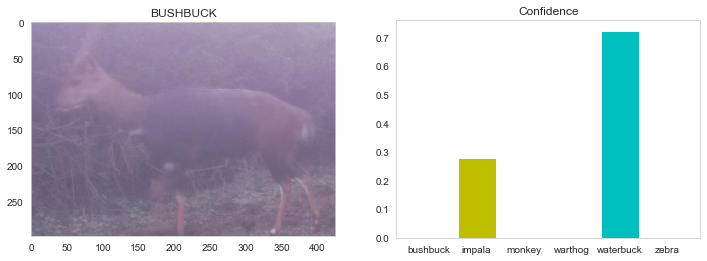

In [134]:
predict_single_image('./data/porinicroppedimages/dataset/test/',random_image);

## Compare model to some baselines

In [63]:
#never forget the slash.
test_images = os.listdir(test_dir)

#time a piece of code.
import time
images_test = []
preds = {}
# load all images
start_load = time.process_time()
i = 0
#Adding multiprocessing.
for imgname in test_images:
    img = Image.open(test_dir + imgname)
    #img = tf.keras.preprocessing.image.load_img(test_dir + img)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    preds[imgname] = [imgname,model.predict(img).argmax(axis = 1)[0]]
    i += 1
#print(preds)
stop_load = time.process_time()
print('Time taken by for loop: ',stop_load-start_load)

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step
Time taken by for loop:  21.65625


In [64]:
df_preds = pd.DataFrame.from_dict(preds, orient='index', columns=['filename','pred'])
prediction_classes = [mapping[p] for p in list(df_preds['pred'])]
df_preds['pred_class'] = prediction_classes
df_preds['true_class'] = list(df_test['Species'])
true = [int(reverse_mapping[p]) for p in list(df_preds['true_class'])]
df_preds['true'] = true 
df_preds.head(20)

,filename,pred,pred_class,true_class,true
2021-09-29-13-44-42.jpg,2021-09-29-13-44-42.jpg,2,MONKEY,MONKEY,2
2021-09-29-13-51-48.jpg,2021-09-29-13-51-48.jpg,1,IMPALA,MONKEY,2
2021-11-02-08-37-48.jpg,2021-11-02-08-37-48.jpg,1,IMPALA,MONKEY,2
2021-12-09-15-02-37.jpg,2021-12-09-15-02-37.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-40.jpg,2021-12-09-15-02-40.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-42.jpg,2021-12-09-15-02-42.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-45.jpg,2021-12-09-15-02-45.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-47.jpg,2021-12-09-15-02-47.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-49.jpg,2021-12-09-15-02-49.jpg,3,WARTHOG,WARTHOG,3
2021-12-09-15-02-52.jpg,2021-12-09-15-02-52.jpg,3,WARTHOG,WARTHOG,3


In [65]:
file = 'outputs/'+name+'_preds.csv'
df_preds.to_csv(file,index=False)
print('File saved as : ',file)

File saved as :  outputs/mobilenet_preds.csv


### Compare your model with others

##### Load all predictions

In [66]:
df_pretrained = pd.read_csv('./outputs/pretrained_cropped_predictions.csv')
df_small_conv = pd.read_csv('./inputs/model_preds.csv')
df_mobilenet = pd.read_csv('./inputs/mobilenet_preds.csv')
df_your_model = pd.read_csv('./'+file)

In [67]:
df_pretrained.head(10)

,Filename,class,confidence,pred_class,pred,true_class,true
0,2021-09-29-13-44-42.jpg,guenon,0.314908,NONE,6,MONKEY,2
1,2021-09-29-13-51-48.jpg,guenon,0.376683,NONE,6,MONKEY,2
2,2021-11-02-08-37-48.jpg,wreck,0.045206,NONE,6,MONKEY,2
3,2021-12-09-15-02-37.jpg,velvet,0.803580,NONE,6,WARTHOG,3
4,2021-12-09-15-02-40.jpg,velvet,0.868584,NONE,6,WARTHOG,3
5,2021-12-09-15-02-42.jpg,velvet,0.926261,NONE,6,WARTHOG,3
6,2021-12-09-15-02-45.jpg,velvet,0.652207,NONE,6,WARTHOG,3
7,2021-12-09-15-02-47.jpg,velvet,0.805909,NONE,6,WARTHOG,3
8,2021-12-09-15-02-49.jpg,velvet,0.855287,NONE,6,WARTHOG,3
9,2021-12-09-15-02-52.jpg,velvet,0.927710,NONE,6,WARTHOG,3


In [68]:
df_pretrained[(df_pretrained['pred']!=6)].shape

(34, 7)

In [69]:
#true class for all models should be same.
print((list(df_pretrained['true'])==list(df_small_conv['true'])))
print((list(df_pretrained['true'])==list(df_mobilenet['true'])))
print((list(df_pretrained['true'])==list(df_your_model['true'])))

True
True
True


### Compare Models

##### Accuracy
!['accuracy'](./figures/accuracy.PNG)

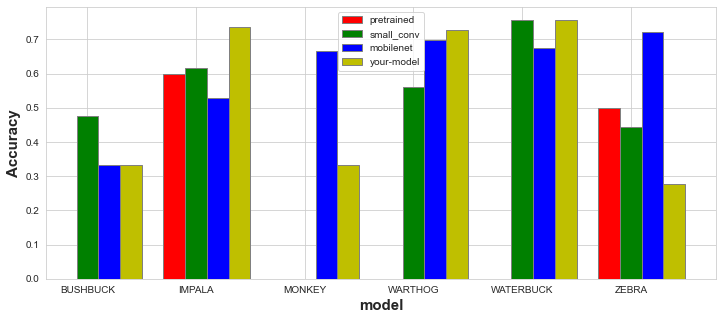

In [70]:
get_scores_and_plot(accuracy_score,'Accuracy') 

#### F1 Score - how well the model performing on class imbalance

F1-score is one of the most important evaluation metrics in machine learning. It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall

!['f1 score'](./figures/f1-score.PNG)

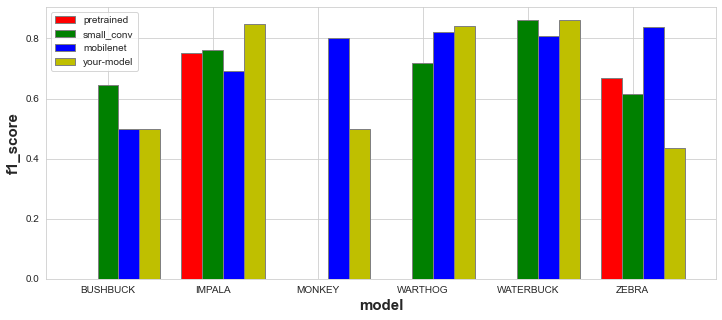

In [71]:
get_scores_and_plot(f1_score,'f1_score') #because of class imbalance

### try to train a better model than mobilenet or try better visualizations

## References

1. [Keras.io TranferLearning and Finetuning](https://keras.io/guides/transfer_learning/)